<a href="https://colab.research.google.com/github/xcellentbird/STUDY/blob/main/AI/CNN_AutoEncoder_and_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [222]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

mnist_data = datasets.FashionMNIST('data', train=True, download=True, transform=transforms.ToTensor())
type(mnist_data), len(mnist_data)


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw




Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw




Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw




Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



(torchvision.datasets.mnist.FashionMNIST, 60000)

In [223]:
IS_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if IS_CUDA else "cpu")

In [224]:
conv = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5)
convt = nn.ConvTranspose2d(in_channels=16, out_channels=3, kernel_size=5)
convt_outpad = nn.ConvTranspose2d(in_channels=16, out_channels=3, kernel_size=5, output_padding=3)

H_out
​
 =(H _in
​
 −1)×stride[0]−2×padding[0]+dilation[0]×(kernel_size[0]−1)+output_padding[0]+1

In [225]:
x = torch.randn(32, 3, 64, 64)
y = conv(x)
x.shape, y.shape, convt(y).shape

(torch.Size([32, 3, 64, 64]),
 torch.Size([32, 16, 60, 60]),
 torch.Size([32, 3, 64, 64]))

In [226]:
class Autoencoder(nn.Module):
  def __init__(self):
    super(Autoencoder, self).__init__()
    self.encoder = nn.Sequential(
        nn.Conv2d(1, 32, 3, stride=2, padding=1),
        nn.SiLU(),
        nn.Conv2d(32, 128, 3, stride=2, padding=1),
        nn.SiLU(),
        nn.Conv2d(128, 512, 7),
    )
    self.decoder = nn.Sequential(
        nn.ConvTranspose2d(512, 128, 7),
        nn.SiLU(),
        nn.ConvTranspose2d(128, 32, 3, stride=2, padding=1, output_padding=1),
        nn.SiLU(),
        nn.ConvTranspose2d(32, 1, 3, stride=2, padding=1, output_padding=1),
        nn.Sigmoid()
    )

  def forward(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return encoded, decoded

In [240]:
def train(model, num_epochs=5, batch_size=64, lr = 1e-3):
  torch.manual_seed(42)

  model = model.to(DEVICE)
  criterion = nn.MSELoss().to(DEVICE)
  optimizer = torch.optim.Adam(model.parameters(),
                               lr=lr,
                               weight_decay=1e-5)
  scheduler = StepLR(optimizer, step_size=10, gamma=0.1)
  train_loader = torch.utils.data.DataLoader(mnist_data,
                                             batch_size=batch_size,
                                             shuffle=True)
  outputs = []
  model.train()
  for epoch in range(num_epochs):
    for data in train_loader:
      img, _ = data
      img = img.to(DEVICE)
      targets, recon = model(img)
      loss = criterion(recon, img)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

    print('Epoch:{},  Loss:{:.4f}'.format(epoch+1, float(loss)))
    outputs.append((epoch, img, recon, targets),)
    scheduler.step()

  return outputs

In [241]:
model = Autoencoder()
max_epochs = 30
outputs = train(model, num_epochs=max_epochs)

Epoch:1,  Loss:0.0091
Epoch:2,  Loss:0.0066
Epoch:3,  Loss:0.0061
Epoch:4,  Loss:0.0045
Epoch:5,  Loss:0.0045
Epoch:6,  Loss:0.0041
Epoch:7,  Loss:0.0045
Epoch:8,  Loss:0.0036
Epoch:9,  Loss:0.0034
Epoch:10,  Loss:0.0028
Epoch:11,  Loss:0.0030
Epoch:12,  Loss:0.0021
Epoch:13,  Loss:0.0023
Epoch:14,  Loss:0.0026
Epoch:15,  Loss:0.0029
Epoch:16,  Loss:0.0022
Epoch:17,  Loss:0.0023
Epoch:18,  Loss:0.0018
Epoch:19,  Loss:0.0019
Epoch:20,  Loss:0.0026
Epoch:21,  Loss:0.0022
Epoch:22,  Loss:0.0020
Epoch:23,  Loss:0.0018
Epoch:24,  Loss:0.0020
Epoch:25,  Loss:0.0020
Epoch:26,  Loss:0.0020
Epoch:27,  Loss:0.0024
Epoch:28,  Loss:0.0016
Epoch:29,  Loss:0.0019
Epoch:30,  Loss:0.0018


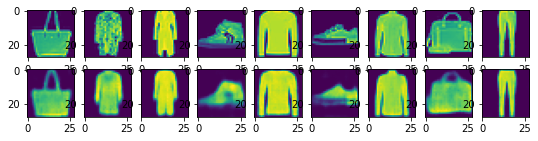

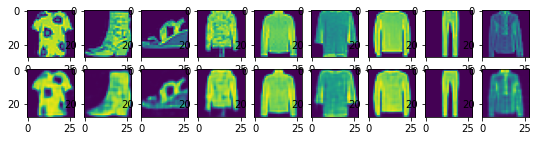

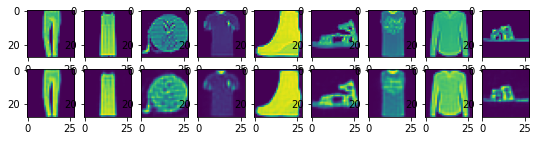

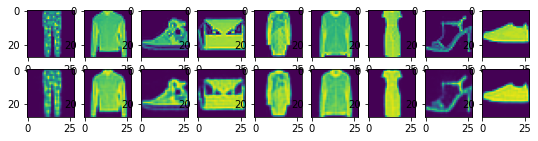

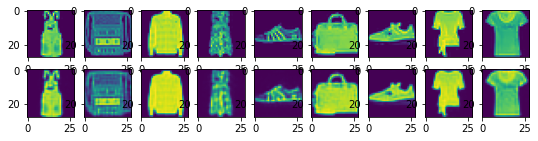

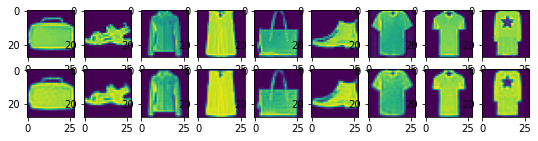

In [242]:
for k in range(0, max_epochs, 5):
  plt.figure(figsize=(9, 2))
  imgs = outputs[k][1].to('cpu').detach().numpy()
  recon = outputs[k][2].to('cpu').detach().numpy()
  for i, item in enumerate(imgs):
    if i >= 9:
      break
    plt.subplot(2, 9, i+1)
    plt.imshow(item[0])
  for i, item in enumerate(recon):
    if i >= 9:
      break
    plt.subplot(2, 9, 9+i+1)
    plt.imshow(item[0])

In [276]:
mnist_test_data = datasets.FashionMNIST('data', train=False, download=True, transform=transforms.ToTensor())
class_to_idx = mnist_test_data.class_to_idx
idx_to_class = {v: k for k, v in class_to_idx.items()}
idx_to_class

{0: 'T-shirt/top',
 1: 'Trouser',
 2: 'Pullover',
 3: 'Dress',
 4: 'Coat',
 5: 'Sandal',
 6: 'Shirt',
 7: 'Sneaker',
 8: 'Bag',
 9: 'Ankle boot'}

In [244]:
model.eval()
model.to(DEVICE)
encoded_outputs = []
test_loader = torch.utils.data.DataLoader(mnist_test_data,
                                             batch_size=64,
                                             shuffle=True,)
for i, (imgs, labels) in enumerate(test_loader):
  imgs = imgs.to(DEVICE)
  
  encoded_output, decoded_output = model(imgs)
  encoded_output = encoded_output.to('cpu').detach().numpy()
  for label, features in zip(labels, encoded_output):
    encoded_outputs.append([label.detach().numpy()] + list(features.squeeze()))

In [245]:
len(encoded_outputs[0])

513

In [246]:
import pandas as pd

In [247]:
df = pd.DataFrame(encoded_outputs)
df = df.rename(columns={0:'label'})

In [248]:
df.head()

,label,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512
0,9,-2.068324,-0.118056,0.063164,0.125716,-0.129711,0.291527,0.456822,-0.308854,1.709883,0.161872,0.375311,0.929756,-0.848022,0.282615,-0.959739,0.071686,0.019696,0.094691,0.926357,0.030675,0.432015,-0.218892,0.140949,-0.256815,-4.239826,0.193926,0.183996,0.016166,0.131093,0.023793,-0.977995,-0.231792,-0.178590,-0.312540,0.943179,1.350523,0.764488,-0.191934,1.557888,...,0.079797,-0.040986,0.445651,0.212707,-0.076159,-0.025234,0.155490,0.354817,0.468674,-0.215962,-0.017340,0.139891,0.209186,0.594963,0.169144,0.022861,-0.678855,8.334609,0.340903,-0.096606,0.149467,4.836730,0.699103,-1.010888,-7.707901,-0.323293,-0.179626,0.291956,-0.431812,0.159923,0.422183,0.752656,0.042279,-0.018798,-0.275372,-0.102796,-0.152354,0.273675,-8.733147,-0.208738
1,9,-1.820133,0.478338,-0.554001,0.023835,0.608462,0.212456,0.113647,-0.891894,-0.008360,-0.059373,0.168128,-0.948014,-0.184199,0.577589,-1.887820,-0.182528,0.068360,-0.139143,0.479532,-0.307848,-0.376483,0.446878,0.100236,-0.381595,-3.224450,0.665874,-0.372272,-0.029832,0.376642,-0.287169,0.844833,-0.796388,-0.154970,-0.597547,-2.917821,-0.918331,1.205718,-0.710943,-1.233661,...,-0.202805,-0.348159,-0.029281,0.481389,0.192741,-0.248770,0.404544,0.408421,0.141964,-0.276736,-0.199492,0.217921,0.367424,-0.050532,0.132559,-0.046964,0.403266,6.258742,0.177314,-0.395854,-0.132001,8.961843,0.529207,0.433116,-7.295291,1.010706,0.344921,0.047979,-0.683382,-0.072499,-0.442823,-0.789039,0.539880,-0.517113,-0.292529,-1.250890,0.133705,0.147872,-6.006214,-0.873016
2,6,0.086827,0.023044,0.211380,0.038294,-0.077506,0.561834,0.021586,-0.071999,-0.691474,0.136512,-1.109512,0.163637,0.470202,-0.471359,0.160154,0.197538,0.296853,0.462297,0.476063,-0.067068,-0.815103,0.207634,-0.043866,0.056770,-2.290994,-0.140489,-0.528217,-0.080204,0.003894,-0.201071,-1.737610,-0.302743,-0.377408,1.345071,-14.808765,-0.010562,1.361009,-0.053046,4.675621,...,-0.299200,0.023067,0.063692,0.180384,-0.139452,-0.617239,-0.420339,0.952177,0.630341,0.049001,0.610147,0.491549,-0.203072,-0.885864,0.196686,-0.010510,0.388923,2.280656,-0.052672,-0.005729,-0.012533,1.037167,-1.087672,-0.811460,-3.371599,-2.043455,-0.335982,-0.320727,-0.511952,1.078340,0.076831,0.008018,-0.344735,0.071310,-0.183237,0.410156,-0.387402,0.694239,-2.451500,-0.218877
3,8,-0.761914,0.635271,0.180654,-0.079904,0.525953,1.384312,0.524743,-0.398991,-0.310040,0.286795,-0.533766,-0.102811,0.759716,0.489469,-1.181613,-0.090007,-0.215329,0.410363,0.034291,0.271852,-0.709081,0.249023,0.358343,-0.068738,-5.629750,0.124087,0.746973,0.110398,0.158875,0.232585,-0.468295,-0.140123,1.141757,-1.140441,-7.400695,-0.429994,-0.870732,0.088692,2.439159,...,0.968773,0.095798,-0.320419,-0.005439,-0.110116,-1.469108,-0.106709,0.455890,0.441652,-0.200893,0.032355,0.073851,1.115193,0.795349,-0.322630,0.122167,-0.457636,2.403948,-0.488809,0.313961,0.225639,6.838463,-0.554821,-0.849726,-8.740753,-0.369776,0.208031,-0.276914,0.075644,-0.345482,0.202198,0.654702,-0.197881,-0.057065,0.228039,1.350261,0.013407,0.360374,-0.656712,0.313815
4,4,0.662576,0.064050,-0.214750,0.257948,0.139219,-0.178566,0.392669,-0.484788,-1.652824,0.090247,-0.261384,-0.714569,0.349128,0.010852,-0.549922,0.136600,0.054049,0.266461,0.007134,0.257564,-0.622535,-0.123038,0.210346,-0.080604,-4.466847,0.105308,-0.404645,0.064151,0.007433,0.035250,2.033410,-0.512422,-0.442331,-0.344895,-11.621453,-0.408764,0.451980,-0.114091,-0.447799,...,-0.341607,-0.076831,0.261561,-0.126273,-0.399377,-1.435953,0.053184,-0.057556,0.835072,-0.065717,0.137149,0.091968,0.620978,0.156395,-0.019879,-0.089177,-0.148158,-3.298146,0.141400,0.071566,0.346696,2.263820,-0.571905,0.499690,-6.633449,0.794993,-0.182462,-0.322970,-0.159307,-0.025812,0.104106,-0.556482,0.1918

In [249]:
df.label = df.label.astype('int')
df.label.unique()

array([9, 6, 8, 4, 5, 7, 2, 0, 1, 3])

In [250]:
cluster_train = df[:8000]
cluster_test = df[8000:]

In [463]:
from sklearn.cluster import KMeans
n_clusters = 2
kmeans = KMeans(n_clusters=n_clusters, random_state=0)

In [464]:
train_clustered = kmeans.fit_transform(cluster_train[range(1, 513)])

In [465]:
cluster = pd.concat([pd.DataFrame(train_clustered), cluster_train.label], axis=1)
cluster.head()

,0,1,label
0,32.435278,29.172530,9
1,34.388173,29.601723,9
2,25.065292,28.546906,6
3,34.805195,32.852177,8
4,20.862986,27.790916,4


In [466]:
cluster.max(axis=1)
cluster.columns

Index([0, 1, 'label'], dtype='object')

In [467]:
import numpy as np

In [468]:
cluster['cluster'] = [np.argmax(k) for k in cluster[range(n_clusters)].values]

In [469]:
cluster.head()

,0,1,label,cluster
0,32.435278,29.172530,9,0
1,34.388173,29.601723,9,0
2,25.065292,28.546906,6,1
3,34.805195,32.852177,8,0
4,20.862986,27.790916,4,1


In [470]:
cluster.label = cluster.label.map(idx_to_class)

In [471]:
cluster

,0,1,label,cluster
0,32.435278,29.172530,Ankle boot,0
1,34.388173,29.601723,Ankle boot,0
2,25.065292,28.546906,Shirt,1
3,34.805195,32.852177,Bag,0
4,20.862986,27.790916,Coat,1
...,...,...,...,...
7995,24.249450,37.421595,T-shirt/top,1
7996,39.107543,34.609256,Sandal,0
7997,22.014478,33.347215,Dress,1
7998,33.564507,22.976313,Sneaker,0


In [472]:
result = cluster.groupby(by='label')['cluster'].describe()
result

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
Ankle boot,802.0,0.032419,0.177221,0.0,0.0,0.0,0.0,1.0
Bag,800.0,0.161250,0.367991,0.0,0.0,0.0,0.0,1.0
Coat,789.0,0.935361,0.246043,0.0,1.0,1.0,1.0,1.0
Dress,810.0,0.935802,0.245256,0.0,1.0,1.0,1.0,1.0
Pullover,792.0,0.901515,0.298157,0.0,1.0,1.0,1.0,1.0
Sandal,804.0,0.002488,0.049844,0.0,0.0,0.0,0.0,1.0
Shirt,802.0,0.874065,0.331983,0.0,1.0,1.0,1.0,1.0
Sneaker,798.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
T-shirt/top,801.0,0.928839,0.257254,0.0,1.0,1.0,1.0,1.0


In [473]:
kmean2 = KMeans(n_clusters=n_clusters,)
label = kmean2.fit_transform(result[['std','mean']])
label_mapping = [np.argmax(k) for k in label]

In [474]:
result['분류']  = label_mapping #['상/하의' if t >= 0.5 else '잡화' for t in result['mean']]

In [475]:
result[['std','mean','분류']]

,std,mean,분류
label,,,
Ankle boot,0.177221,0.032419,1
Bag,0.367991,0.161250,1
Coat,0.246043,0.935361,0
Dress,0.245256,0.935802,0
Pullover,0.298157,0.901515,0
Sandal,0.049844,0.002488,1
Shirt,0.331983,0.874065,0
Sneaker,0.000000,0.000000,1
T-shirt/top,0.257254,0.928839,0


In [481]:
def clustering(n_clusters, datas):
  from sklearn.cluster import KMeans
  import numpy as np

  kmeans = KMeans(n_clusters=n_clusters, random_state=0)
  train_clustered = kmeans.fit_transform(cluster_train[range(1, 513)])
  cluster = pd.concat([pd.DataFrame(train_clustered), cluster_train.label], axis=1)
  cluster['cluster'] = [np.argmax(k) for k in cluster[range(n_clusters)].values]

  cluster.label = cluster.label.map(idx_to_class)
  result = cluster.groupby(by='label')['cluster'].describe()

  kmean2 = KMeans(n_clusters=n_clusters,)
  label = kmean2.fit_transform(result[['std','mean']])
  label_mapping = [np.argmax(k) for k in label]
  result['분류']  = label_mapping

  return result[['std','mean','분류']]

In [483]:
c1 = clustering(2, cluster_test)
c1

,std,mean,분류
label,,,
Ankle boot,0.177221,0.032419,1
Bag,0.367991,0.161250,1
Coat,0.246043,0.935361,0
Dress,0.245256,0.935802,0
Pullover,0.298157,0.901515,0
Sandal,0.049844,0.002488,1
Shirt,0.331983,0.874065,0
Sneaker,0.000000,0.000000,1
T-shirt/top,0.257254,0.928839,0


In [486]:
c1['idx_label'] = [class_to_idx[c] for c in c1.index]

In [487]:
c1

,std,mean,분류,idx_label
label,,,,
Ankle boot,0.177221,0.032419,1,9
Bag,0.367991,0.161250,1,8
Coat,0.246043,0.935361,0,4
Dress,0.245256,0.935802,0,3
Pullover,0.298157,0.901515,0,2
Sandal,0.049844,0.002488,1,5
Shirt,0.331983,0.874065,0,6
Sneaker,0.000000,0.000000,1,7
T-shirt/top,0.257254,0.928839,0,0


In [528]:
new_df = df[df['label'].isin(c1[c1['분류'] == 0]['idx_label'].unique())]
new_df.index = range(len(new_df))

l = new_df['label']
d = new_df[range(1,513)]

In [529]:
r = pd.DataFrame(KMeans(n_clusters=2).fit_transform(d))

In [530]:
r = r.join(l, how='right')

In [531]:
r['cluster'] = [np.argmax(k) for k in r[range(n_clusters)].values]

r.label = r.label.map(idx_to_class)
result = r.groupby(by='label')['cluster'].describe()

kmean2 = KMeans(n_clusters=n_clusters,)
label = kmean2.fit_transform(result[['std','mean']])
label_mapping = [np.argmax(k) for k in label]
result['분류']  = label_mapping

result[['std','mean','분류']]

,std,mean,분류
label,,,
Coat,0.277527,0.916,1
Dress,0.381860,0.177,0
Pullover,0.104355,0.989,1
Shirt,0.272972,0.919,1
T-shirt/top,0.351265,0.856,1
Trouser,0.205198,0.044,0
